# Cognitive Science and AI
### Assignment 3: Textual Brain Encoder and Decoder

**Kshitijaa Jaglan** \
2019115005

In [3]:
# IMPORTS
import numpy as np
from sklearn.model_selection import KFold
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge

In [4]:
# accessing the dataset provided

data_1 = np.load("dataset/subj1.npy", allow_pickle=True).item()
data_2 = np.load("dataset/subj2.npy", allow_pickle=True).item()

keys = data_1.keys()

In [5]:
data_1

{'language': array([[-4.80611567, -4.58436357, -0.34787147, ...,  3.76586198,
          3.01573205,  1.45281303],
        [ 3.37973718,  0.60592965,  3.7661773 , ...,  7.52970958,
          4.08423533,  3.35879479],
        [-0.23922059,  0.31543971,  2.68080231, ...,  4.57699837,
          4.08193925,  3.18332798],
        ...,
        [ 2.02910958,  2.63542635,  3.01952658, ...,  6.41630626,
          7.36548418,  4.33442073],
        [ 3.0204297 ,  2.9499358 ,  4.35247309, ...,  5.48655412,
          5.26227501,  3.86641549],
        [-2.76721844,  0.20592889,  1.42064169, ...,  4.68680384,
          4.79302549,  3.97274799]]),
 'vision': array([[ 10.92026478,  13.88504383,   8.03793147, ..., -10.11296459,
          -9.93924486,  -8.42341808],
        [ -6.25776885,  -0.30330221,  -2.65186041, ...,  -2.15170392,
          -4.44855112,  -1.38273663],
        [  4.09027124,   8.57396632,   0.64009411, ...,  -6.41515448,
          -5.71263532,  -3.50753665],
        ...,
        [  6.6

In [6]:
data_2

{'language': array([[-2.25322683, -2.39321356,  0.1533733 , ...,  2.76130192,
          4.37065187,  3.57052749],
        [-2.82828427, -4.41575901, -4.19305779, ...,  3.89285708,
         -0.38465431,  0.78448012],
        [-3.30454561, -4.59135782, -4.8106763 , ...,  4.89161413,
         -0.13283525, -1.05881144],
        ...,
        [-3.81550039, -0.71621773, -6.57268647, ..., -1.52482375,
         -3.71932279, -2.58959862],
        [ 0.38524359,  6.16102712, -2.30326807, ...,  4.31241884,
         -2.33780703,  1.0393514 ],
        [ 0.53532407,  2.26287025,  0.68298466, ...,  2.87013659,
         -0.03498023,  0.23324292]]),
 'vision': array([[ 4.10287145,  3.0778673 ,  3.68367034, ..., -2.27123073,
         -0.86356005,  3.05250828],
        [-2.75300367,  1.94114138, -2.27681171, ..., -3.25587555,
         -5.59536257, -5.97779961],
        [-0.2197131 ,  6.87834871,  4.49228766, ...,  2.15383954,
          0.45071431,  0.12141517],
        ...,
        [ 2.29124792, 11.2440604

In [7]:
# getting the sentences from stimuli.txt
SENTENCES = []
with open('dataset/stimuli.txt') as file:
    for line in file:
        SENTENCES.append(line.strip('\n'))

## Sentence Embeddings using BERT

In [8]:
model = SentenceTransformer('all-distilroberta-v1')

In [9]:
embeddings = model.encode(SENTENCES)

In [10]:
embeddings.shape

(627, 768)

## Evaluation and loss functions

In [11]:
# cos distance
from scipy.spatial.distance import cosine

In [12]:
# 2v2 accuracy
def accuracy_2v2(v1, v2):
    n = len(v1)
    
    nc2 = n*(n-1)/2
    sum_acc = 0
    
    for i in range(n-1):
        for j in range(i+1, n):
            if (cosine(v1[i], v2[i]) + cosine(v1[j], v2[j])) < (cosine(v1[i], v1[j]) + cosine(v1[j], v2[i])):
                sum_acc += 1
                
                
    return sum_acc/nc2

In [13]:
def accuracy_pc(v1, v2):
    n = len(v1)
    total = 0
    
    for i in range(n):
        total += np.corrcoef(v1[i], v2[i])
        
    return total/n

## Decoding

In [44]:
class Decoder():
    def __init__(self, n, data, embeddings):
        self.data = data
        self.n = n
        
        self.indices = np.arange(len(embeddings))
        self.kf = KFold(n_splits=n, shuffle=False, random_state=None)
        
    def train(self):
        self.decoded = {}
        for key in self.data.keys():
            print("Key: ", key)
            self.decoded[key] = {}
            eval_pc = 0
            eval_2v2 = 0
            
            
            
            for train_ids, test_ids in self.kf.split(self.indices):
                trainX, trainY = self.data[key][train_ids], embeddings[train_ids]
                testX, testY = self.data[key][test_ids], embeddings[test_ids]
                
                model = Ridge(alpha = 1)
                model.fit(trainX, trainY)
                
                predicted = model.predict(testX)
                
                eval_pc += accuracy_pc(testY, predicted)
                eval_2v2 += accuracy_2v2(testY, predicted)
            self.decoded[key]["pc"] = eval_pc[0, 1]/self.n
            self.decoded[key]["2v2"] = eval_2v2/self.n
            
    def report(self):
        for key in self.data.keys():
            print("> ", key)
            print("2v2: ", self.decoded[key]["2v2"])
            print("PC: ", self.decoded[key]["pc"])
            
        return self.decoded
        

### Subject 1

In [45]:
decoder_subj_1 = Decoder(3, data_1, embeddings)
decoder_subj_1.train()
report_decoder_1 = decoder_subj_1.report()

Key:  language
Key:  vision
Key:  dmn
Key:  task
>  language
2v2:  0.8487302171512697
PC:  0.1602492030074432
>  vision
2v2:  0.8485615261931051
PC:  0.16448072405388228
>  dmn
2v2:  0.8191479573058521
PC:  0.15262956751939646
>  task
2v2:  0.8469512943197154
PC:  0.17361931761559793


In [21]:
report_decoder_1

{'language': {'pc': 0.1602492030074432, '2v2': 0.8487302171512697},
 'vision': {'pc': 0.16448072405388228, '2v2': 0.8485615261931051},
 'dmn': {'pc': 0.15262956751939646, '2v2': 0.8191479573058521},
 'task': {'pc': 0.17361931761559793, '2v2': 0.8469512943197154}}

In [22]:
import matplotlib.pyplot as plt


# pc
vals_pc_1 = [report_decoder_1[key]["pc"] for key in keys]

# 2v2
vals_2v2_1 = [report_decoder_1[key]["2v2"] for key in keys]

**With Pearson Correlation for subject 1**

Text(0.5, 1.0, 'Subject 1 | Pearson Correlation')

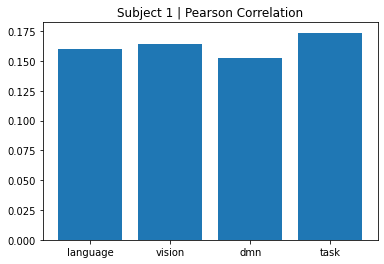

In [47]:
plt.bar(keys, vals_pc_1)
plt.title("Subject 1 | Pearson Correlation")

**With 2v2 accuracy for subject 1**

Text(0.5, 1.0, 'Subject 1 | 2v2')

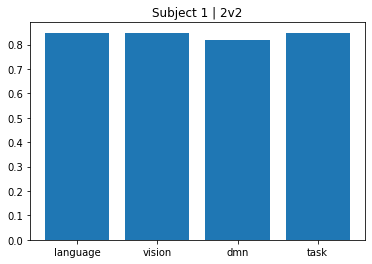

In [48]:
plt.bar(keys, vals_2v2_1)
plt.title("Subject 1 | 2v2")

### Subject 2

In [25]:
decoder_subj_2 = Decoder(3, data_2, embeddings)
decoder_subj_2.train()
report_decoder_2 = decoder_subj_2.report()

Key:  language
Key:  vision
Key:  dmn
Key:  task
>  language
2v2:  0.7914519690835481
PC:  0.14012307508204397
>  vision
2v2:  0.8225524475524475
PC:  0.15272578079192725
>  dmn
2v2:  0.8006839651576495
PC:  0.1412803279137329
>  task
2v2:  0.7685253343148081
PC:  0.13883735960011612


In [26]:
report_decoder_2

{'language': {'pc': 0.14012307508204397, '2v2': 0.7914519690835481},
 'vision': {'pc': 0.15272578079192725, '2v2': 0.8225524475524475},
 'dmn': {'pc': 0.1412803279137329, '2v2': 0.8006839651576495},
 'task': {'pc': 0.13883735960011612, '2v2': 0.7685253343148081}}

In [27]:
# pc
vals_pc_2 = [report_decoder_2[key]["pc"] for key in keys]

# 2v2
vals_2v2_2 = [report_decoder_2[key]["2v2"] for key in keys]

**With Pearson Correlation for subject 2**

Text(0.5, 1.0, 'Subject 2 | Pearson Correlation')

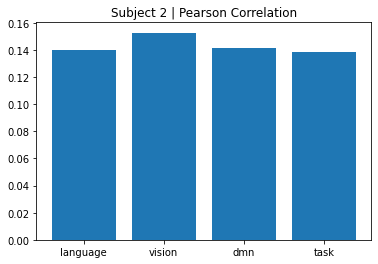

In [51]:
plt.bar(keys, vals_pc_2)
plt.title("Subject 2 | Pearson Correlation")

**With 2v2 Accuracy for subject 2**

Text(0.5, 1.0, 'Subject 2 | 2v2')

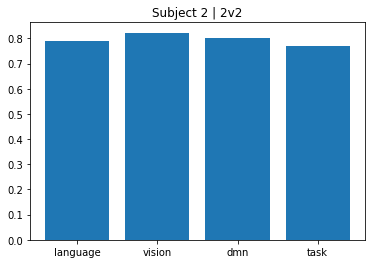

In [52]:
plt.bar(keys, vals_2v2_2)
plt.title("Subject 2 | 2v2")

**Inferences and analysis:** In the decoder, as can be seen from the graphs above, the accuracy is most with `task`, followed by `vision` and `language` at a close third


_Note: the performance depends significantly on the models used, which in this case is `all-distilroberta-v1`_

## Encoding

In [32]:
class Encoder():
    def __init__(self, n, data, embeddings):
        self.data = data
        self.n = n
        
        self.indices = np.arange(len(embeddings))
        self.kf = KFold(n_splits=n, shuffle=False, random_state=None)
        
    def train(self):
        self.decoded = {}
        for key in self.data.keys():
            print("Key: ", key)
            self.decoded[key] = {}
            eval_pc = 0
            eval_2v2 = 0
            
            
            
            for train_ids, test_ids in self.kf.split(self.indices):
                trainX, trainY = embeddings[train_ids], self.data[key][train_ids]
                testX, testY = embeddings[train_ids], self.data[key][test_ids]
                
                model = Ridge(alpha = 1)
                model.fit(trainX, trainY)
                
                predicted = model.predict(testX)
                
                eval_pc += accuracy_pc(testY, predicted)
                eval_2v2 += accuracy_2v2(testY, predicted)
            self.decoded[key]["pc"] = eval_pc[0][1]/self.n
            self.decoded[key]["2v2"] = eval_2v2/self.n
            
    def report(self):
        for key in self.data.keys():
            print("> ", key)
            print("2v2: ", self.decoded[key]["2v2"])
            print("PC: ", self.decoded[key]["pc"])
            
        return self.decoded
        

### Subject 1

In [33]:
encoder_subj_1 = Encoder(3, data_1, embeddings)
encoder_subj_1.train()
report_encoder_1 = encoder_subj_1.report()

Key:  language
Key:  vision
Key:  dmn
Key:  task
>  language
2v2:  0.6716813887866518
PC:  0.6790922566013622
>  vision
2v2:  0.6317323027849344
PC:  0.7272369629801676
>  dmn
2v2:  0.5201509017298491
PC:  0.4306317305671888
>  task
2v2:  0.5363452337136547
PC:  0.45912743818025814


In [34]:
report_encoder_1

{'language': {'pc': 0.6790922566013622, '2v2': 0.6716813887866518},
 'vision': {'pc': 0.7272369629801676, '2v2': 0.6317323027849344},
 'dmn': {'pc': 0.4306317305671888, '2v2': 0.5201509017298491},
 'task': {'pc': 0.45912743818025814, '2v2': 0.5363452337136547}}

In [35]:
# pc
vals_pc_1_en = [report_encoder_1[key]["pc"] for key in keys]

# 2v2
vals_2v2_1_en = [report_encoder_1[key]["2v2"] for key in keys]

**With Pearson Correlation for subject 1**

Text(0.5, 1.0, 'Subject 1 | Pearson Correlation')

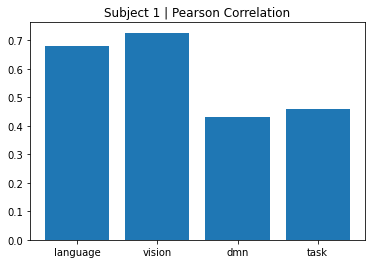

In [49]:
plt.bar(keys, vals_pc_1_en)
plt.title("Subject 1 | Pearson Correlation")

**With 2v2 accuracy for subject 1**

Text(0.5, 1.0, 'Subject 1 | 2v2')

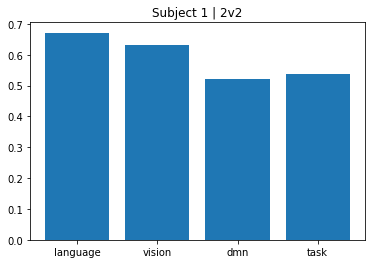

In [50]:
plt.bar(keys, vals_2v2_1_en)
plt.title("Subject 1 | 2v2")

**Analysis and inference:**

As can be seen in the graphs above, the accuracy is most for vision (Pearson correlation) or Language (with 2v2 accuracy). Overall, language and vision perform pretty good, followed by task by a wide margin and dmn coming close to the same.


The above observation is in line with the paper reffered in the class for this assignment

### Subject 2

In [38]:
encoder_subj_2 = Encoder(3, data_2, embeddings)
encoder_subj_2.train()
report_encoder_2 = encoder_subj_2.report()

Key:  language
Key:  vision
Key:  dmn
Key:  task
>  language
2v2:  0.6236504723346828
PC:  0.4927203377750114
>  vision
2v2:  0.7051435406698564
PC:  0.7061633131475054
>  dmn
2v2:  0.5796681388786652
PC:  0.37748706168141194
>  task
2v2:  0.6175009201324991
PC:  0.33201641507590024


In [57]:
report_encoder_2

{'language': {'pc': 0.4927203377750114, '2v2': 0.6236504723346828},
 'vision': {'pc': 0.7061633131475054, '2v2': 0.7051435406698564},
 'dmn': {'pc': 0.37748706168141194, '2v2': 0.5796681388786652},
 'task': {'pc': 0.33201641507590024, '2v2': 0.6175009201324991}}

In [39]:
# pc
vals_pc_2_en = [report_encoder_2[key]["pc"] for key in keys]

# 2v2
vals_2v2_2_en = [report_encoder_2[key]["2v2"] for key in keys]

**With Pearson Correlation for subject 2**

Text(0.5, 1.0, 'Subject 2 | Pearson Correlation')

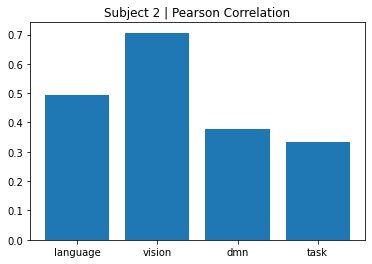

In [54]:
plt.bar(keys, vals_pc_2_en)
plt.title("Subject 2 | Pearson Correlation")

**With 2v2 accuracy for subject 2**

Text(0.5, 1.0, 'Subject 2 | 2v2')

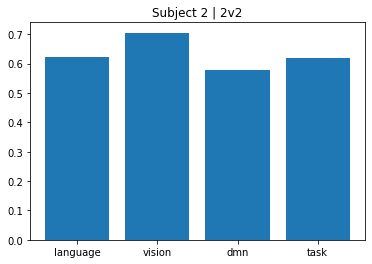

In [56]:
plt.bar(keys, vals_2v2_2_en)
plt.title("Subject 2 | 2v2")

**Analysis and inference:**

As can be seen in the graphs above, the accuracy is most for vision (Pearson correlation) or Language (with 2v2 accuracy). Overall, language and vision perform pretty good, followed by task by a wide margin and dmn coming close to the same.


The above observation is in line with the paper reffered in the class for this assignment

Moreover, it is also observed that `dmn` and `task` are comparatively better for Pearson Correlation than 2v2 accuracy